In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [5]:
DATA_PATH = os.path.join('..', 'data', 'processed', 'ncr_properties_cleaned.parquet')

# Load the Parquet file
df = pd.read_parquet(DATA_PATH)

print(f"✅ Loaded {len(df)} rows from Parquet.")
df.sample()

✅ Loaded 12324 rows from Parquet.


,title,url,city,location,price,price_raw,area,area_raw,bedrooms,bathrooms,...,gym,lift,parking,vastu_compliant,property_hash,scraped_at,society_name,sector,locality,price_per_sqft
3589,"4 BHK Flat for Sale in Sare Petioles, Sector...",https://www.magicbricks.com/propertyDetails/4-...,Gurugram,Unknown,17500000,₹1.75 Cr₹7955 per sqft,2200.0,,4,0,...,0,0,0,0,d983ebbfaa2afa6de7a5cc4b0c09358d,2026-02-02 15:33:00.433516,Sare Petioles,Sector 92,Gurgaon,7955.0


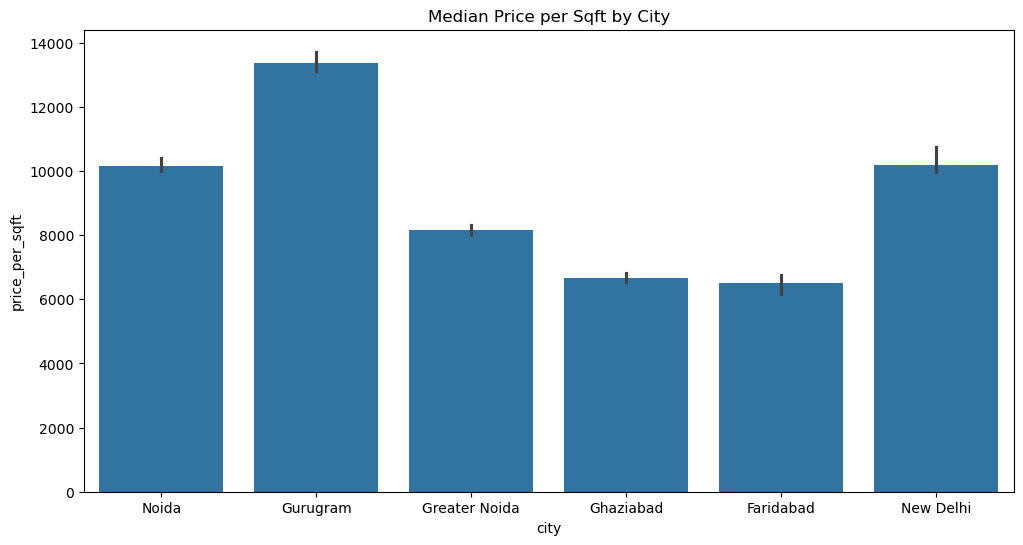

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='price_per_sqft', data=df, estimator='median')
plt.title('Median Price per Sqft by City')
plt.show()

<Axes: xlabel='area', ylabel='price'>

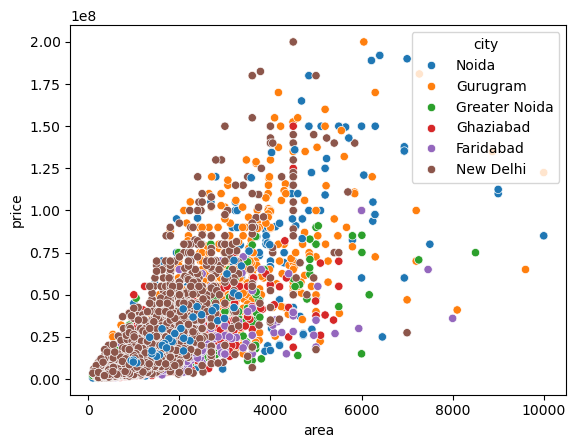

In [11]:
sns.scatterplot(x='area', y='price', hue='city', data=df)

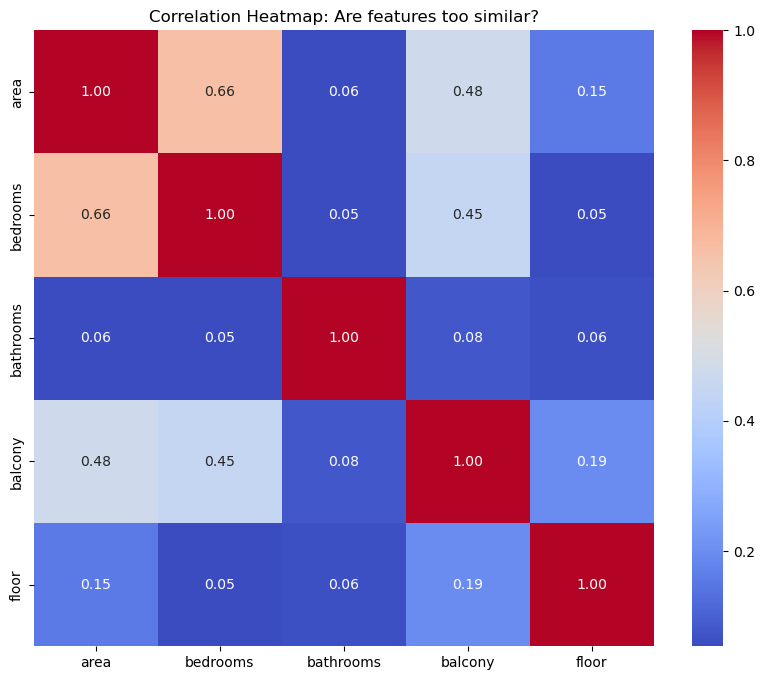


--- Variance Inflation Factor (VIF) ---
     feature       VIF
1   bedrooms  7.640443
0       area  7.119323
3    balcony  4.011690
4      floor  1.185949
2  bathrooms  1.046964


In [12]:

import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor



# 2. Select numerical features for the model
# We exclude 'price_per_sqft' because it's derived from our target (price)
features = ['area', 'bedrooms', 'bathrooms', 'balcony', 'floor']
X = df[features].fillna(0) # Ensure no NaNs for the math

# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Are features too similar?")
plt.show()

# 4. Variance Inflation Factor (VIF)
# VIF > 5-10 indicates high multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("\n--- Variance Inflation Factor (VIF) ---")
print(vif_data.sort_values(by="VIF", ascending=False))

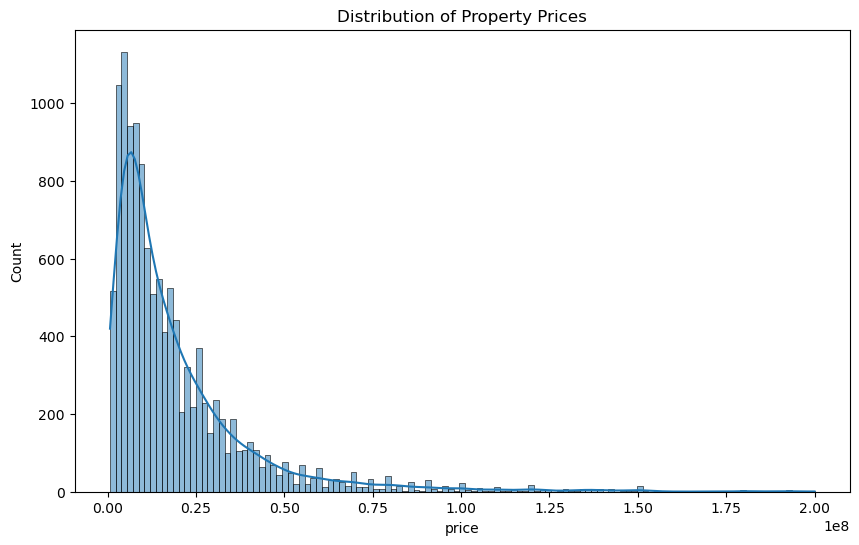

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Property Prices')
plt.show()

# If the graph looks like a "mountain" pushed to the left, 
# we will use np.log(df['price']) to make regression more accurate.

--- MODEL PERFORMANCE ---
R2 Score (Accuracy): 0.7976
Mean Absolute Error: ₹5,140,579


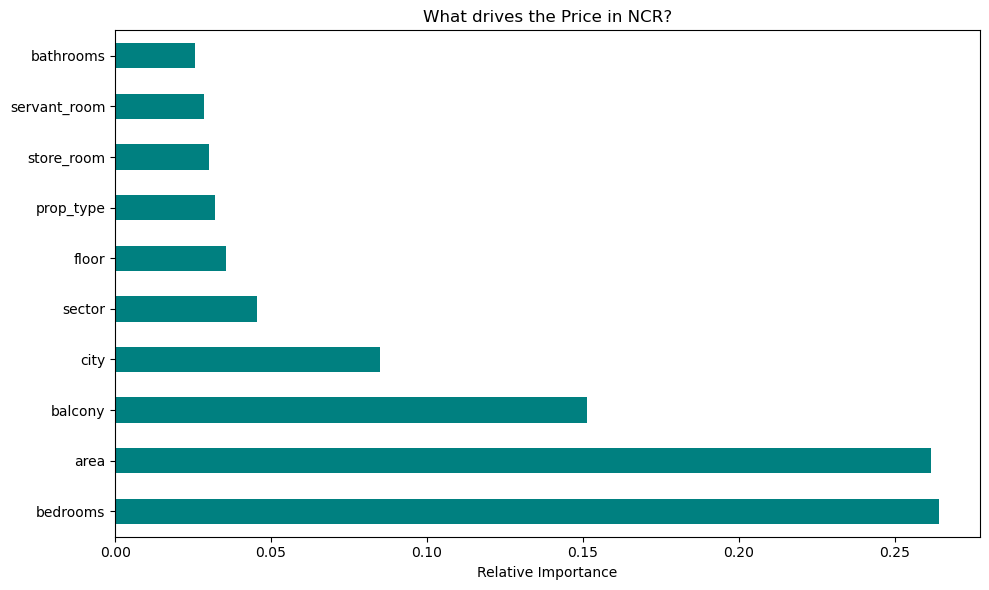

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# 1. LOAD DATA
DATA_PATH = '../data/processed/ncr_properties_cleaned.parquet'
df = pd.read_parquet(DATA_PATH)

# 2. FEATURE SELECTION & PREPROCESSING
# We include binary features like pooja_room, servant_room for better accuracy
categorical_cols = ['city', 'sector', 'prop_type', 'furnished']
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'balcony', 'floor', 
                  'pooja_room', 'servant_room', 'store_room']

df_model = df.copy()

# Encode Categorical text into numbers
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le # Store for inverse mapping later if needed

# 3. LOG TRANSFORMATION
# Real estate prices are 'Right-Skewed'. Log-transform makes the distribution normal.
y = np.log1p(df_model['price']) 
X = df_model[categorical_cols + numerical_cols]

# 4. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. XGBOOST MODEL
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.05,
    colsample_bytree=0.8,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 6. EVALUATION (Convert log back to Rupees)
y_pred_log = xgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)     # Inverse of log
y_test_real = np.expm1(y_test)   # Inverse of log

r2 = r2_score(y_test_real, y_pred)
mae = mean_absolute_error(y_test_real, y_pred)

print(f"--- MODEL PERFORMANCE ---")
print(f"R2 Score (Accuracy): {r2:.4f}")
print(f"Mean Absolute Error: ₹{mae:,.0f}")

# 7. FEATURE IMPORTANCE PLOT
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("What drives the Price in NCR?")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

Mean Absolute Percentage Error (MAPE): 29.85%


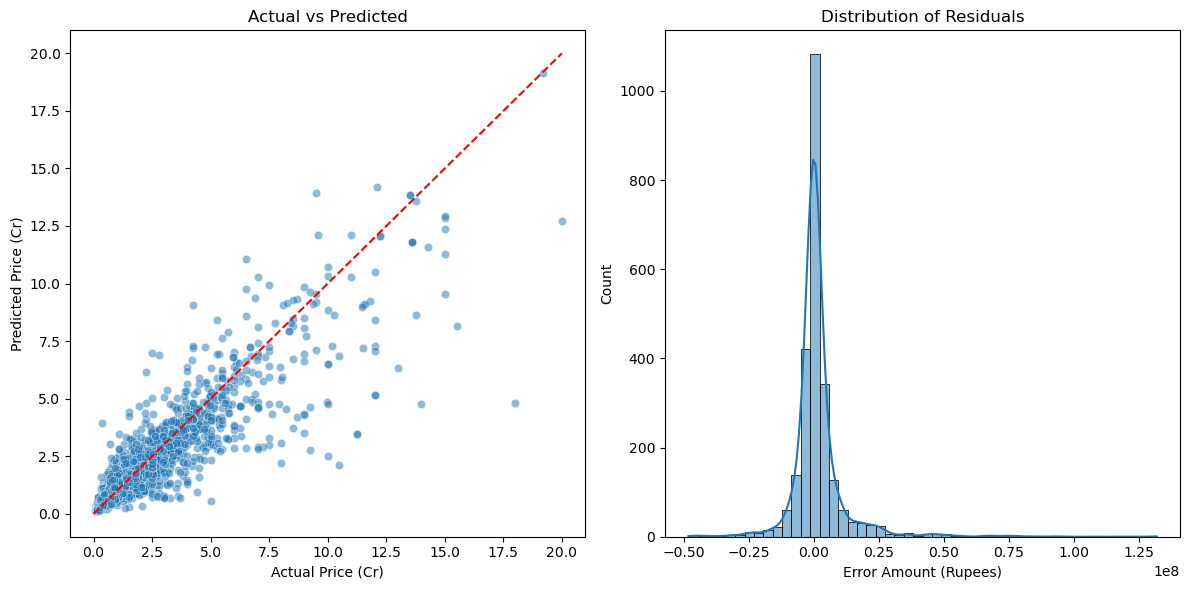

In [15]:
# 1. Calculate Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_real - y_pred) / y_test_real)) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 2. Visualize Residuals (Errors)
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_real/1e7, y=y_pred/1e7, alpha=0.5)
plt.plot([0, 20], [0, 20], color='red', linestyle='--') # Perfect prediction line
plt.xlabel("Actual Price (Cr)")
plt.ylabel("Predicted Price (Cr)")
plt.title("Actual vs Predicted")

# Plot Error Distribution
plt.subplot(1, 2, 2)
sns.histplot(y_test_real - y_pred, kde=True, bins=50)
plt.xlabel("Error Amount (Rupees)")
plt.title("Distribution of Residuals")

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# 1. LOAD DATA
df = pd.read_parquet('../data/processed/ncr_properties_cleaned.parquet')

# 2. ADVANCED FEATURE ENGINEERING
# A. Target Encoding for Sector: Map each sector to its average price per sqft
# This is a massive signal for the model.
sector_map = df.groupby('sector')['price_per_sqft'].median().to_dict()
df['sector_avg_rate'] = df['sector'].map(sector_map)

# B. Interaction Features
df['area_per_room'] = df['area'] / (df['bedrooms'] + df['bathrooms'] + 1)
df['luxury_score'] = df[['pooja_room', 'servant_room', 'store_room', 'pool', 'gym']].sum(axis=1)

# 3. PREPARE FOR MODEL
# Use the new 'sector_avg_rate' instead of just the sector name
categorical_cols = ['city', 'prop_type', 'furnished']
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'balcony', 'floor', 
                  'sector_avg_rate', 'area_per_room', 'luxury_score']

df_model = df.copy()

# Simple encoding for low-cardinality categories
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))

X = df_model[categorical_cols + numerical_cols]
y = np.log1p(df_model['price'])

# 4. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. XGBOOST WITH TUNED PARAMS
model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,             # Deeper trees to capture sector nuances
    learning_rate=0.03,      # Slower learning for better generalization
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. EVALUATE
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

r2 = r2_score(y_test_real, y_pred)
mae = mean_absolute_error(y_test_real, y_pred)
mape = np.mean(np.abs((y_test_real - y_pred) / y_test_real)) * 100

print(f"--- UPGRADED PERFORMANCE ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: ₹{mae:,.0f}")
print(f"MAPE: {mape:.2f}%")

--- UPGRADED PERFORMANCE ---
R2 Score: 0.8300
MAE: ₹4,687,561
MAPE: 27.53%
